<div align="center"; span style="color:#336699"><b><h2> Track Global Precipitation JAXA GSMAP </h2></b></div>
<hr style="border:2px solid #0077b9;">
<br/>
<div style="text-align: center;font-size: 90%;">
    Helvécio B. Leal Neto, <sup><a href="https://orcid.org/0000-0002-7526-2094"><i class="fab fa-lg fa-orcid" style="color: #a6ce39"></i></a></sup>
    Alan J. P. Calheiros<sup><a href="https://orcid.org/0000-0002-7526-2094"><i class="fab fa-lg fa-orcid" style="color: #a6ce39"></i></a></sup>
    <br/><br/>
    National Institute for Space Research (INPE)
    <br/>
    Avenida dos Astronautas, 1758, Jardim da Granja, São José dos Campos, SP 12227-010, Brazil
    <br/><br/>
    Contact: <a href="mailto:helvecio.neto@inpe.br">helvecio.neto@inpe.br</a>, <a href="mailto:alan.calheiros@inpe.br">alan.calheiros@inpe.br</a>
    <br/><br/>
    Last Update: Nov 4, 2024
</div>

<br/>

<div style="text-align: justify;  margin-left: 25%; margin-right: 25%;">
<b>Abstract.</b> This Jupyter Notebook demonstrates the use of PyFortracc to track precipitation within Hurricane Milton, <br>
which occurred from October 7 to October 10, 2024. In this example, we utilize JAXA GSMaP data to analyze the hurricane's <br>
precipitation patterns and movement, showcasing PyFortracc's capabilities for tracking global precipitation systems.
</div>    
<br/>
<div style="text-align: justify;  margin-left: 15%; margin-right: 15%;font-size: 75%; border-style: solid; border-color: #0077b9; border-width: 1px; padding: 5px;">
    <b>In this example, we will use pyfortracc to compute track of precipitating systems over the globe and explore the output data after the algorithm workflow.
</b>
    <div style="margin-left: 10px; margin-right: 10px; margin-top:10px">
      <p> Leal Neto, H.B.; Calheiros, A.J.P.;  pyForTraCC Algorithm. São José dos Campos, INPE, 2024. <a href="https://github.com/fortracc-project/pyfortracc" target="_blank"> Online </a>. </p>
    </div>
</div>

### Schedule
 [1. Installation](#install)<br>
 [2. Input Data (Download from Google Earth Engine)](#input)<br>
 [3. Read Function](#data)<br>
 [4. Parameters (Name_list)](#namelist)<br>
 [5. Tracking Routine](#track)<br>
 [6. Tracking Table](#tracktable)<br>
 [7. Tracking Visualization](#visualization)<br>
 [8. Statistics](#statistics)

<a id='install'></a>
#### 1. Installation

- Installing the pyFortraCC package can be done using the pip install command. 
All dependencies will be installed in the current Python environment and the code will be ready to use.

- Install Google Earth Engine Python API.


In [ ]:
# pyFortracc
!pip3 install --upgrade git+https://github.com/fortracc/pyfortracc.git@main#egg=pyfortracc &> /dev/null
# Google Earth Engine API
!pip3 install --upgrade earthengine-api xee> /dev/null 2>&1

Import all necessary libraries for this example.

In [88]:
import ee
import xarray as xr
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

import logging
logging.getLogger('googleapiclient.http').setLevel(logging.ERROR)

Set the Google Earth Engine authentication.

-  Create an project using link https://console.cloud.google.com/projectcreate

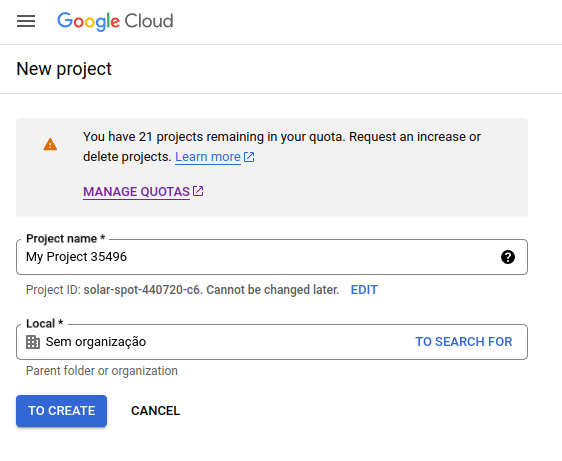

-  Activate Earth Engine API https://console.cloud.google.com/apis/library/earthengine.googleapis.com

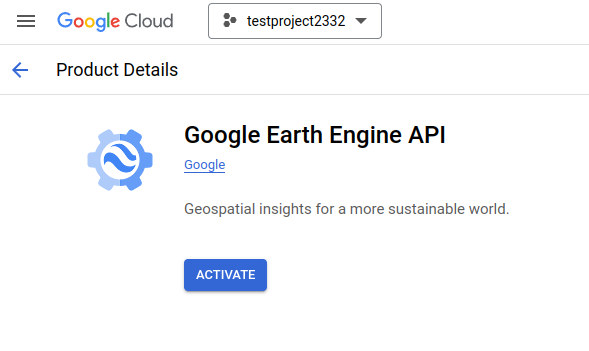

- Copy the project ID and paste in the code below.

In [89]:
# Authenticate to the Earth Engine servers
project_id = 'project_name'
ee.Authenticate()
ee.Initialize(project=project_id)

### Tracking Precipitation from Hurricane Milton

In this example, we set up parameters to track the precipitation associated with Hurricane Milton, which occurred from October 7 to October 10, 2024.

- **Analysis Period**: The `start_date` and `end_date` variables define the time range to focus specifically on the hurricane period, ensuring that the analysis targets precipitation data during this event.
- **Precipitation Variable**: `variable` is set to `hourlyPrecipRate`, allowing us to observe hourly precipitation rates. This variable is essential for monitoring rainfall intensity associated with the hurricane over time.
- **Spatial Scale**: `scale` is set to 0.25 degrees, specifying the spatial resolution of the data. This value provides a good balance between spatial detail and computational performance, suitable for analyzing global-scale events like a hurricane.
- **Data Retrieval and Filtering**: The precipitation image collection `JAXA/GPM_L3/GSMaP/v8/operational` from Earth Engine is filtered by the specified dates and variable, focusing on relevant precipitation data.
- **Data Loading**: We use xarray to load the filtered data (`ic`) into a Dataset format, with the specified projection and scale. This facilitates the manipulation and analysis of geospatial data, which will be used to monitor the trajectory and intensity of hurricane precipitation.

These parameters provide a basis for analyzing precipitation from significant weather events, such as Hurricane Milton, using JAXA GSMaP's global data collection.


In [ ]:
# Get collection and put into a dataset
start_date = '2024-10-07'
end_date = '2024-10-10'
variable = 'hourlyPrecipRate'
scale = 0.25

# Get the data
ic = ee.ImageCollection('JAXA/GPM_L3/GSMaP/v8/operational').filterDate(start_date, end_date).select(variable)
ds = xr.open_dataset(ic, engine='ee', crs='EPSG:4326', scale=scale)

# Save the dataset as files
def save_single_file(ds, t, output_dir, var):
    timestamp = pd.to_datetime(t.values).strftime('%Y%m%dT%H%M%S')
    ds.sel(time=t)[[var]].to_netcdf(f"{output_dir}/{timestamp}.nc")

def save_times_as_files(ds, output_dir, var):
    os.makedirs(output_dir, exist_ok=True)
    for f in glob.glob(f"{output_dir}/*.nc"):
        os.remove(f)
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(save_single_file, ds, t, output_dir, var) for t in ds.time]
        for _ in tqdm(as_completed(futures), total=len(futures), desc="Downloading files"):
            pass
# Download and save files
save_times_as_files(ds, output_dir='input/', var=variable)

<a id='data'></a>
#### 3. Read Function:
### Data Reading Function

The following function, `read_function`, is designed to load and preprocess data from a specified file path.

- **Function Purpose**: `read_function` opens a data file, specifically using the `xarray` library to handle data in the form of a DataArray. This function is intended for use with data files structured in formats that `xarray` supports (e.g., NetCDF).
- **Parameter**: The function takes one parameter, `path`, which is the file path to the data file to be read.
- **Data Extraction and Transformation**:
  - `xr.open_dataarray(path).data` reads the data from the file into an array format.
  - `np.rot90(data)` rotates the array by 90 degrees, likely to adjust the orientation for analysis or visualization.
  - `[:: -1]` reverses the order of the rows after rotation, flipping the data vertically.
  
- **Return Value**: The function returns the transformed data as a NumPy array, ready for further processing or visualization.

This function is essential for preparing data to be compatible with the `pyFortracc` algorithm, which requires the data in a two-dimensional NumPy array format. This ensures the data structure is appropriate for pyFortracc's tracking processes.


In [72]:
# Create a function to read the data
def read_function(path):
  data = xr.open_dataarray(path).data
  return np.rot90(data)[::-1]

<a id='namelist'></a>
#### 4. Parameters

In this example, a threshold of **2.5 mm/h** has been chosen for clustering precipitation data, with a minimum cluster size of **20 pixels**. Given a pixel size of 0.25 degrees, this corresponds to clusters with an approximate size of **5 square degrees** (20 pixels * 0.25 degrees² per pixel).

- **Parameter Configuration (`name_list`)**:
    - `input_path`: Specifies the directory containing the input files for tracking (`input/`).
    - `output_path`: Defines the directory where the output files will be saved (`output/`).
    - `thresholds`: Sets the precipitation threshold for clustering (2.5 mm/h), meaning only areas with precipitation at or above this level will be considered.
    - `min_cluster_size`: Specifies the minimum cluster size (20 pixels) to filter out small or insignificant clusters in the tracking process.
    - `operator`: Sets the threshold operator (`>=`), meaning clusters are created for areas with precipitation greater than or equal to 2.5 mm/h.
    - `timestamp_pattern`: Defines the file naming pattern for timestamps (`'%Y%m%dT%H%M%S.nc'`), allowing the algorithm to identify and order files by time.
    - `delta_time`: Sets the time difference between successive frames to 60 minutes, helping track precipitation changes over time.
    - `edges`: Enables borders in the tracking process, which can improve accuracy by defining boundaries.
    - `lon_min`, `lon_max`, `lat_min`, `lat_max`: Set the spatial extent (longitude and latitude) for tracking, using the minimum and maximum coordinates from the dataset `ds`.

These settings ensure that PyFortracc can detect clusters of significant precipitation, applying spatial and temporal constraints to the data while maintaining a focus on regions meeting the 2.5 mm/h threshold.


In [76]:
# Set name_list
name_list = {}
name_list['input_path'] = 'input/' # Path to the input files
name_list['output_path'] = 'output/' # Path to the output files
name_list['thresholds'] = [2.5] # Thresholds for the clustering
name_list['min_cluster_size'] = [20] # Minimum cluster size
name_list['operator'] = '>=' # Operator for the threshold
name_list['timestamp_pattern'] = ['%Y%m%dT%H%M%S.nc'] # Timestamp pattern
name_list['delta_time'] = 60 # Delta time in minutes
name_list['edges'] = True # Set to apply borders into the track
name_list['lon_min'] = ds.lon.data[0] # Set the longitude minimum
name_list['lon_max'] = ds.lon.data[-1] # Set the longitude maximum
name_list['lat_min'] = ds.lat.data[0] # Set the latitude minimum
name_list['lat_max'] = ds.lat.data[-1] # Set the latitude maximum

<a id='track'></a>
#### 5. Track Routine

The tracking module groups the main objectives of the algorithm. This module uses the tracking parameters and the data reading function, and only with this information is it possible to carry out the entire tracking process of the objects present in the input data. The output of this module will be the tracking files, and they will be located in the trackingtable directory, which gives the name to the same entity that we will see in the next topic. Furthermore, it is worth highlighting that each step of the tracking module groups other modules (Features Extraction, Spatial Operations, Cluster linking and Result Containment) intended for the object tracking process.
You could also run all the functions in one line using the track function:

In [ ]:
# Import track and plot functions
from pyfortracc import track


# Run pyfortracc
track(name_list, read_function, parallel=True)

To visualize the initial tracking information, we use the `plot` utility from the `pyfortracc` library to identify the unique cluster identifier (UID) associated with Hurricane Milton. This plot focuses on the storm's origin area in the Gulf of Mexico by applying a zoom over this region, specifically for the event's starting date. This setup allows us to examine precipitation patterns and ensure correct tracking of the hurricane's initial formation.

In [ ]:
from pyfortracc import plot, plot_animation

# Set lat and lon to Mexican Gulf
mg_lat_min, mg_lat_max, mg_lon_min, mg_lon_max = 15, 35, -100, -75
zoom_region = [mg_lon_min, mg_lon_max, mg_lat_min, mg_lat_max]

# Plot the tracking data for periods of time. 
# Note: If the min and max value is a larger time interval, the plot will be slower
plot(read_function=read_function, # Read function
                          figsize=(8,7), # Figure size
                          name_list=name_list, # Name list dictionary
                          timestamp = start_date,
                          info_col_name=False,
                          cbar_title='mm/h', # Colorbar title
                          cmap='turbo', # Colormap
                          min_val=1, # Min value
                          max_val=25, # Max value
                          nan_value=1, # NaN value
                          cbar_extend='max', # Colorbar extend
                          nan_operation=np.less_equal, # NaN operation
                          box_fontsize=10, # Box fontsize
                          zoom_region=zoom_region,
                          )

In [ ]:
# Set the uid of the hurricane
hurricane_uid = 46

The tracking table generated by the algorithm provides extensive information on tracked clusters over the specified period. This table contains detailed historical data and statistics for each cluster, which can be analyzed further. In this example, we use the unique identifier (UID) of Hurricane Milton to filter the table with `loc`, displaying the full history and statistical information tracked by the algorithm for this specific cluster. This allows us to observe the hurricane's evolution and gain insights into its precipitation patterns, size, intensity, and other metrics across its lifespan.

In [ ]:
# Read the tracking table
tracking_files = sorted(glob.glob(name_list['output_path'] + '/track/trackingtable/*.parquet'))
tracking_table = pd.concat(pd.read_parquet(f) for f in tracking_files)
filterd_cluster = tracking_table[tracking_table['uid'] == hurricane_uid].set_index('timestamp')
display(filterd_cluster.head(3))

The figure illustrates the changes in cluster size and maximum precipitation for Hurricane Milton over its lifetime. The orange line with circular markers represents the **cluster size in pixels**, while the blue line with circular markers represents the **maximum precipitation rate (in mm/h)**. 

- **Status Indicators**: The labels at the top display the lifecycle stages, indicating moments where the cluster was split (`SPL`), merged (`MRG`), or continued (`CON`). This information is critical for understanding the structural changes within the hurricane over time.
- **Lifetime Tracking**: The secondary x-axis shows the total hours elapsed since tracking began, helping to contextualize each stage within the hurricane's timeline.


In [ ]:
# Plot the tracking table for the hurricane
fig, ax1 = plt.subplots(1, 1, figsize=(15, 6))
ax2 = ax1.twinx()
ax3 = ax2.twiny()
f1 = filterd_cluster['size'].plot(ax=ax1, marker='o', linestyle='dashed', color='C1', zorder=5, linewidth=3, markersize=10)
f2 = filterd_cluster['max'].plot(ax=ax2, marker='o', linestyle='dotted', color='C0', zorder=1, linewidth=2, markersize=10)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
labels = ['Size (pixels)']
labels2 = ['Max Precipitation(mm/h)']
ax2.legend(lines + lines2, labels + labels2, loc=0)
ax1.set_ylabel('Size (pixels)')
ax2.set_ylabel('Max Precipitation(mm/h)')
ax3.set_xticks(range(0, int(filterd_cluster.lifetime.max()) + 1, 60))
ax3.tick_params(axis='x', which='major', labelsize=8, rotation=45)
ax1.set_xticks(filterd_cluster.index)
ax1.set_xticklabels([ts.strftime('%H:%M') for ts in filterd_cluster.index], rotation=45, ha='right', fontsize=8)
# Status
for i in range(len(filterd_cluster)):
    ax3.text(filterd_cluster.lifetime[i] - 20, 230.5, filterd_cluster['status'][i], fontsize=5, fontweight='bold')
# Labels
ax1.set_xlabel('Tracking Start at ' + filterd_cluster.index.min().strftime('%Y-%m-%d %H:%M'), labelpad=12, fontsize=12, fontweight='bold')
ax3.set_xlabel('Status and Lifetime (hours)', labelpad=16, fontsize=16, fontweight='bold')
ax3.set_xlim(filterd_cluster.lifetime.min(), filterd_cluster.lifetime.max())
ax3.grid(True, which='both', axis='x', linestyle='--', alpha=0.5)
ax1.grid(True, which='both', axis='y', linestyle='--', alpha=0.2)
plt.tight_layout()
plt.show()


To visualize the evolution of Hurricane Milton over time, we use the `plot_animation` utility from the `pyfortracc` library. By setting the `uid` to the specific identifier of the hurricane (UID 46), the animation focuses on tracking Milton's path and precipitation intensity from start to end dates. A zoom is applied over the Gulf of Mexico region to highlight the hurricane's trajectory, and additional information (e.g., UID, maximum precipitation, size, and lifetime) is displayed for each frame, enabling a detailed view of the hurricane's development.

In [ ]:
# the plot will be slower
plot_animation(read_function=read_function, # Read function
                          figsize=(10,7), # Figure size
                          name_list=name_list, # Name list dictionary
                          start_timestamp = start_date, # Start timestamp
                          end_timestamp= end_date, # End timestamp
                          info_col_name=True,
                          info_cols=['uid','max','size','lifetime'],
                          cbar_title='mm/h', # Colorbar title
                          cmap='turbo', # Colormap
                          min_val=1, # Min value
                          max_val=25, # Max value
                          nan_value=1, # NaN value
                          nan_operation=np.less_equal, # NaN operation
                          box_fontsize=10, # Box fontsize
                          zoom_region=zoom_region, # Zoom region
                          uid_list=[hurricane_uid], # The uid of Milton Hurricane
                          traj_linewidth=3,
                          )